# DexYCB Model Evaluation with Standard Metrics

This notebook evaluates a trained model on the DexYCB test set and computes:
- **MPJPE**: Mean Per Joint Position Error in millimeters
- **PA-MPJPE**: Procrustes-aligned MPJPE after optimal rigid alignment
- **PCK**: Percentage of Correct Keypoints within various thresholds
- **AUC**: Area Under Curve for PCK from 0-50mm
- **Diversity**: Standard deviation of predictions to measure mode collapse

## Key Updates Applied:
1. **Proper checkpoint loading**: Extracts model config from checkpoint and handles mode collapse wrapper
2. **BFloat16 handling**: Converts BFloat16 images to Float32 for DINOv2 compatibility
3. **Camera parameter fixes**: Ensures camera_params dictionary is properly formatted
4. **Robust model loading**: Handles both wrapped and unwrapped model architectures
5. **Checkpoint info display**: Shows training history and best metrics from checkpoint

Based on the train_full_featured notebook implementation.

In [1]:
# Setup and imports
import sys
import os

# Add the parent directory to Python path
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('./')))
os.environ['DEX_YCB_DIR'] = '/home/n231/231nProjectV2/dex-ycb-toolkit/data'
sys.path.insert(0, parent_dir)

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import json
from typing import Dict, List, Tuple, Optional
import pandas as pd

# Import our modules - use full paths from project root
from Advanced_Manipulation_Transformer.data.enhanced_dexycb import EnhancedDexYCBDataset
from Advanced_Manipulation_Transformer.models.unified_model import UnifiedManipulationTransformer
from Advanced_Manipulation_Transformer.evaluation.evaluator import ComprehensiveEvaluator

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


/home/n231/miniconda3/envs/env2.0/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/n231/miniconda3/envs/env2.0/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Configuration
config = {
    # Dataset settings
    'dex_ycb_dir': os.environ.get('DEX_YCB_DIR', '/home/n231/231nProjectV2/dex-ycb'),
    'test_split': 's0_val',  # DexYCB doesn't have 'test', use 'val' for evaluation
    'batch_size': 32,
    'num_workers': 4,
    
    # Model checkpoint
    'checkpoint_path': '/home/n231/231nProjectV2/Advanced_Manipulation_Transformer/notebooks/outputs/full_featured/checkpoints/checkpoint_epoch_50.pth',  # Update with your model path
    
    # Evaluation settings
    'save_results': True,
    'results_dir': 'evaluation_results',
    'visualize_samples': 10,  # Number of samples to visualize
    
    # Metric thresholds
    'pck_thresholds': [5, 10, 15, 20, 30, 40, 50],  # mm
    'auc_min': 0,
    'auc_max': 50,
}

# Create results directory
if config['save_results']:
    os.makedirs(config['results_dir'], exist_ok=True)

In [3]:
# Load test dataset
print(f"Loading DexYCB test split: {config['test_split']}")

test_dataset = EnhancedDexYCBDataset(
    split=config['test_split'],
    dexycb_root=config['dex_ycb_dir'],  # Changed from dex_ycb_dir to dexycb_root
    use_cache=True,
    augment=False,  # No augmentation for testing
    sequence_length=1  # Single frame evaluation
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

print(f"Test set size: {len(test_dataset)} samples")
print(f"Number of batches: {len(test_loader)}")

Loading DexYCB test split: s0_val
Test set size: 23200 samples
Number of batches: 725


In [4]:
# Load model
print("Loading model...")

# Load checkpoint first to extract config
if os.path.exists(config['checkpoint_path']):
    checkpoint = torch.load(config['checkpoint_path'], map_location=device)
    
    # Extract model config from checkpoint
    if 'config' in checkpoint:
        # Full config available
        full_config = checkpoint['config']
        if 'model' in full_config:
            model_config = full_config['model']
        else:
            model_config = full_config
        print("Using model config from checkpoint")
    else:
        # Use default config
        print("No config found in checkpoint, using default config")
        model_config = {
            'hidden_dim': 1024,
            'contact_hidden_dim': 512,
            'use_mano_vertices': True,
            'use_sigma_reparam': True,
            'use_attention_fusion': True,
            'num_refinement_steps': 2,
            'max_objects': 10,
            'num_object_classes': 100,
            'num_contact_points': 10,
            'dropout': 0.15,
            'freeze_layers': 12
        }
    
    # Initialize model with correct config
    model = UnifiedManipulationTransformer(model_config)
    
    # Check if model was wrapped with mode collapse prevention
    mode_collapse_wrapped = False
    if 'model_state_dict' in checkpoint:
        # Check if state dict has mode collapse wrapper prefix
        state_dict_keys = list(checkpoint['model_state_dict'].keys())
        if state_dict_keys and ('base_model.' in state_dict_keys[0] or '_orig_mod.base_model.' in state_dict_keys[0]):
            mode_collapse_wrapped = True
    
    if mode_collapse_wrapped or 'mode_collapse_wrapped' in checkpoint:
        from Advanced_Manipulation_Transformer.solutions.mode_collapse import ModeCollapsePreventionModule
        mode_collapse_config = checkpoint.get('mode_collapse_config', {
            'noise_std': 0.01,
            'drop_path_rate': 0.1,
            'mixup_alpha': 0.2
        })
        model = ModeCollapsePreventionModule.wrap_model(model, mode_collapse_config)
        print("Applied mode collapse prevention wrapper")
    
    # Load model weights
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        
        # Handle compiled model state dict (_orig_mod prefix)
        if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
            print("Detected compiled model checkpoint, removing _orig_mod prefix...")
            # Remove _orig_mod prefix
            new_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith('_orig_mod.'):
                    new_state_dict[k[10:]] = v  # Remove '_orig_mod.' prefix
                else:
                    new_state_dict[k] = v
            state_dict = new_state_dict
        
        # Now try to load the state dict
        try:
            model.load_state_dict(state_dict, strict=True)
            print("Loaded model weights successfully (strict mode)")
        except RuntimeError as e:
            # Try non-strict loading
            missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
            print(f"Loaded model weights (non-strict mode)")
            if missing_keys:
                print(f"  Missing keys: {len(missing_keys)} keys")
                print(f"  First 5: {missing_keys[:5]}")
            if unexpected_keys:
                print(f"  Unexpected keys: {len(unexpected_keys)} keys")
                print(f"  First 5: {unexpected_keys[:5]}")
                    
    elif 'ema_state_dict' in checkpoint:
        # Use EMA weights if available (usually better for evaluation)
        print("Using EMA weights for evaluation")
        state_dict = checkpoint['ema_state_dict']
        
        # Handle compiled model state dict
        if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
            print("Detected compiled model checkpoint, removing _orig_mod prefix...")
            new_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith('_orig_mod.'):
                    new_state_dict[k[10:]] = v
                else:
                    new_state_dict[k] = v
            state_dict = new_state_dict
        
        model.load_state_dict(state_dict, strict=False)
    else:
        # Direct checkpoint (just state dict)
        state_dict = checkpoint
        
        # Handle compiled model state dict
        if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
            print("Detected compiled model checkpoint, removing _orig_mod prefix...")
            new_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith('_orig_mod.'):
                    new_state_dict[k[10:]] = v
                else:
                    new_state_dict[k] = v
            state_dict = new_state_dict
            
        model.load_state_dict(state_dict)
    
    print(f"Loaded checkpoint from: {config['checkpoint_path']}")
    
    # Print checkpoint info if available
    if 'epoch' in checkpoint:
        print(f"Checkpoint epoch: {checkpoint['epoch']}")
    if 'history' in checkpoint:
        history = checkpoint['history']
        if 'val_mpjpe' in history and history['val_mpjpe']:
            print(f"Checkpoint best val MPJPE: {min(history['val_mpjpe']):.2f} mm")
    if 'best_val_mpjpe' in checkpoint:
        print(f"Best validation MPJPE: {checkpoint['best_val_mpjpe']:.2f} mm")
    if 'best_val_loss' in checkpoint:
        print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")
else:
    raise FileNotFoundError(f"Checkpoint not found: {config['checkpoint_path']}")

model = model.to(device)
model.eval()

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel info:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model type: {type(model).__name__}")
print(f"Mode collapse wrapped: {mode_collapse_wrapped}")

Loading model...


/tmp/ipykernel_1384124/593641566.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config['checkpoint_path'], map_location=device)


Using model config from checkpoint


/home/n231/miniconda3/envs/env2.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Applied mode collapse prevention wrapper
Detected compiled model checkpoint, removing _orig_mod prefix...
Loaded model weights successfully (strict mode)
Loaded checkpoint from: /home/n231/231nProjectV2/Advanced_Manipulation_Transformer/notebooks/outputs/full_featured/checkpoints/checkpoint_epoch_50.pth
Checkpoint epoch: 49
Checkpoint best val MPJPE: 207.52 mm
Best validation MPJPE: 207.52 mm
Best validation loss: 0.8801

Model info:
Total parameters: 516,090,192
Trainable parameters: 362,902,864
Model type: WrappedModel
Mode collapse wrapped: True


In [5]:
# Custom evaluation functions for detailed metrics

def compute_mpjpe(pred_joints, gt_joints):
    """Compute Mean Per Joint Position Error"""
    # pred_joints, gt_joints: [B, 21, 3]
    errors = torch.norm(pred_joints - gt_joints, dim=-1)  # [B, 21]
    return errors

def procrustes_align(pred, gt):
    """Align predicted pose to ground truth using Procrustes analysis"""
    # Center the points
    pred_centered = pred - pred.mean(axis=0)
    gt_centered = gt - gt.mean(axis=0)
    
    # Compute optimal rotation
    H = pred_centered.T @ gt_centered
    U, _, Vt = np.linalg.svd(H)
    R_opt = Vt.T @ U.T
    
    # Handle reflection
    if np.linalg.det(R_opt) < 0:
        Vt[-1, :] *= -1
        R_opt = Vt.T @ U.T
    
    # Apply transformation
    aligned = pred_centered @ R_opt.T
    aligned += gt.mean(axis=0)
    
    return aligned

def compute_pa_mpjpe(pred_joints, gt_joints):
    """Compute Procrustes-aligned MPJPE"""
    pa_errors = []
    
    for i in range(pred_joints.shape[0]):
        pred_np = pred_joints[i].cpu().numpy()
        gt_np = gt_joints[i].cpu().numpy()
        
        # Align prediction to ground truth
        aligned_pred = procrustes_align(pred_np, gt_np)
        
        # Compute error
        error = np.mean(np.linalg.norm(aligned_pred - gt_np, axis=-1))
        pa_errors.append(error)
    
    return np.array(pa_errors)

def compute_pck(errors, thresholds):
    """Compute Percentage of Correct Keypoints for different thresholds"""
    pck_values = {}
    
    for threshold in thresholds:
        # Check how many predictions are within threshold
        correct = (errors < threshold).float().mean()
        pck_values[f'PCK@{threshold}mm'] = correct.item() * 100
    
    return pck_values

def compute_auc(errors, min_threshold=0, max_threshold=50, num_steps=100):
    """Compute Area Under Curve for PCK metric"""
    thresholds = np.linspace(min_threshold, max_threshold, num_steps)
    pck_values = []
    
    for threshold in thresholds:
        pck = (errors < threshold).float().mean().item()
        pck_values.append(pck)
    
    # Compute AUC using trapezoidal rule
    auc = np.trapz(pck_values, thresholds) / (max_threshold - min_threshold)
    
    return auc, thresholds, pck_values

def compute_diversity(predictions):
    """Compute prediction diversity (std deviation)"""
    # predictions: List of [B, 21, 3] tensors
    all_preds = torch.cat(predictions, dim=0)  # [N, 21, 3]
    
    # Compute std deviation per joint and average (convert to mm)
    std_per_joint = torch.std(all_preds, dim=0) * 1000  # [21, 3] in mm
    mean_std = std_per_joint.mean().item()
    
    # Also compute overall std
    overall_std = torch.std(all_preds.reshape(-1, 63), dim=0).mean().item() * 1000
    
    return {
        'mean_std_per_joint': mean_std,
        'overall_std': overall_std,
        'std_per_joint': std_per_joint.cpu().numpy()
    }

In [6]:
# Run evaluation
print("Starting evaluation...")

# Storage for metrics
all_mpjpe = []
all_pa_mpjpe = []
all_predictions = []
per_joint_errors = {i: [] for i in range(21)}

# Joint names for visualization
joint_names = [
    'Wrist', 'Thumb_1', 'Thumb_2', 'Thumb_3', 'Thumb_tip',
    'Index_1', 'Index_2', 'Index_3', 'Index_tip',
    'Middle_1', 'Middle_2', 'Middle_3', 'Middle_tip',
    'Ring_1', 'Ring_2', 'Ring_3', 'Ring_tip',
    'Pinky_1', 'Pinky_2', 'Pinky_3', 'Pinky_tip'
]

# Helper function to fix batch data types (from train_full_featured)
def fix_batch_for_model(batch, model):
    '''Fix dtype issues in batch, especially for camera parameters'''
    # Get model dtype
    model_dtype = next(model.parameters()).dtype
    
    # Fix camera intrinsics if present
    if 'camera_intrinsics' in batch and isinstance(batch['camera_intrinsics'], torch.Tensor):
        batch['camera_intrinsics'] = batch['camera_intrinsics'].to(model_dtype)
    
    # Create camera_params dict if needed
    if 'camera_params' not in batch and 'camera_intrinsics' in batch:
        batch['camera_params'] = {'intrinsics': batch['camera_intrinsics']}
    
    # Fix camera_params dictionary
    if 'camera_params' in batch and isinstance(batch['camera_params'], dict):
        fixed_params = {}
        for key, value in batch['camera_params'].items():
            if isinstance(value, torch.Tensor):
                fixed_params[key] = value.to(model_dtype)
            else:
                fixed_params[key] = value
        batch['camera_params'] = fixed_params
    
    return batch

# Evaluation loop
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                for k, v in batch.items()}
        
        # CRITICAL FIX: Convert BFloat16 images to Float32 for DINOv2 (from train_full_featured)
        if 'image' in batch and batch['image'].dtype == torch.bfloat16:
            batch['image'] = batch['image'].float()
        
        # Fix camera parameters
        batch = fix_batch_for_model(batch, model)
        
        # Forward pass
        try:
            outputs = model(batch)
        except Exception as e:
            print(f"Error in forward pass: {e}")
            continue
        
        # Extract predictions and ground truth
        # Use refined joints if available, otherwise use coarse predictions
        if 'hand_joints' in outputs:
            pred_joints = outputs['hand_joints']  # [B, 21, 3]
        elif 'hand' in outputs and 'joints_3d_refined' in outputs['hand']:
            pred_joints = outputs['hand']['joints_3d_refined']
        elif 'hand' in outputs and 'joints_3d' in outputs['hand']:
            pred_joints = outputs['hand']['joints_3d']
        else:
            print("Warning: No hand joint predictions found in model output")
            continue
            
        # Get ground truth - handle different possible keys
        if 'hand_joints_3d' in batch:
            gt_joints = batch['hand_joints_3d']   # [B, 21, 3]
        elif 'hand_joints' in batch:
            gt_joints = batch['hand_joints']
        else:
            print("Warning: No ground truth hand joints found in batch")
            continue
        
        # Store predictions for diversity
        all_predictions.append(pred_joints.cpu())
        
        # Compute MPJPE (convert to mm)
        mpjpe_errors = compute_mpjpe(pred_joints, gt_joints) * 1000  # [B, 21] in mm
        all_mpjpe.extend(mpjpe_errors.mean(dim=1).cpu().numpy())  # Mean over joints
        
        # Store per-joint errors
        for joint_idx in range(21):
            per_joint_errors[joint_idx].extend(
                mpjpe_errors[:, joint_idx].cpu().numpy()
            )
        
        # Compute PA-MPJPE (convert to mm)
        pa_mpjpe = compute_pa_mpjpe(pred_joints, gt_joints) * 1000
        all_pa_mpjpe.extend(pa_mpjpe)

# Convert to arrays
all_mpjpe = np.array(all_mpjpe)
all_pa_mpjpe = np.array(all_pa_mpjpe)

print("\nEvaluation complete!")
print(f"Evaluated {len(all_mpjpe)} samples")

Starting evaluation...


Evaluating:   0%|          | 0/725 [00:00<?, ?it/s]/home/n231/231nProjectV2/Advanced_Manipulation_Transformer/data/enhanced_dexycb.py:426: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental


Evaluation complete!
Evaluated 23200 samples


In [7]:
# Compute all metrics
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

# 1. MPJPE
mpjpe_mean = np.mean(all_mpjpe)
mpjpe_std = np.std(all_mpjpe)
print(f"\nMPJPE: {mpjpe_mean:.2f} ± {mpjpe_std:.2f} mm")

# 2. PA-MPJPE
pa_mpjpe_mean = np.mean(all_pa_mpjpe)
pa_mpjpe_std = np.std(all_pa_mpjpe)
print(f"PA-MPJPE: {pa_mpjpe_mean:.2f} ± {pa_mpjpe_std:.2f} mm")

# 3. PCK at different thresholds
all_errors_tensor = torch.tensor(all_mpjpe)
pck_results = compute_pck(all_errors_tensor, config['pck_thresholds'])
print("\nPCK Results:")
for threshold, pck in pck_results.items():
    print(f"  {threshold}: {pck:.2f}%")

# 4. AUC
auc, auc_thresholds, auc_pck_values = compute_auc(
    all_errors_tensor, 
    config['auc_min'], 
    config['auc_max']
)
print(f"\nAUC (0-50mm): {auc:.3f}")

# 5. Diversity
diversity_metrics = compute_diversity(all_predictions)
print(f"\nDiversity Metrics:")
print(f"  Mean STD per joint: {diversity_metrics['mean_std_per_joint']:.4f} mm")
print(f"  Overall STD: {diversity_metrics['overall_std']:.4f} mm")

# Check for mode collapse
if diversity_metrics['mean_std_per_joint'] < 0.5:
    print("  ⚠️ WARNING: Low diversity detected - possible mode collapse!")

print("="*50)


EVALUATION RESULTS

MPJPE: 299.51 ± 432.69 mm
PA-MPJPE: 27.75 ± 23.06 mm

PCK Results:
  PCK@5mm: 0.00%
  PCK@10mm: 0.00%
  PCK@15mm: 0.06%
  PCK@20mm: 0.11%
  PCK@30mm: 0.27%
  PCK@40mm: 0.84%
  PCK@50mm: 1.88%

AUC (0-50mm): 0.004

Diversity Metrics:
  Mean STD per joint: 233.4111 mm
  Overall STD: 233.4111 mm


/tmp/ipykernel_1384124/2657138363.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(pck_values, thresholds) / (max_threshold - min_threshold)


In [8]:
# Per-joint analysis
print("\nPer-Joint MPJPE Analysis:")
joint_mpjpe = {}
for joint_idx in range(21):
    joint_errors = np.array(per_joint_errors[joint_idx])
    joint_mpjpe[joint_idx] = np.mean(joint_errors)
    print(f"  {joint_names[joint_idx]:12s}: {joint_mpjpe[joint_idx]:.2f} mm")

# Find worst performing joints
worst_joints = sorted(joint_mpjpe.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nWorst performing joints:")
for joint_idx, error in worst_joints:
    print(f"  {joint_names[joint_idx]:12s}: {error:.2f} mm")


Per-Joint MPJPE Analysis:
  Wrist       : 295.52 mm
  Thumb_1     : 293.68 mm
  Thumb_2     : 292.86 mm
  Thumb_3     : 294.44 mm
  Thumb_tip   : 296.44 mm
  Index_1     : 299.56 mm
  Index_2     : 304.80 mm
  Index_3     : 305.18 mm
  Index_tip   : 307.50 mm
  Middle_1    : 299.56 mm
  Middle_2    : 302.24 mm
  Middle_3    : 302.11 mm
  Middle_tip  : 303.63 mm
  Ring_1      : 298.62 mm
  Ring_2      : 299.68 mm
  Ring_3      : 299.13 mm
  Ring_tip    : 300.86 mm
  Pinky_1     : 298.40 mm
  Pinky_2     : 298.89 mm
  Pinky_3     : 297.97 mm
  Pinky_tip   : 298.65 mm

Worst performing joints:
  Index_tip   : 307.50 mm
  Index_3     : 305.18 mm
  Index_2     : 304.80 mm
  Middle_tip  : 303.63 mm
  Middle_2    : 302.24 mm


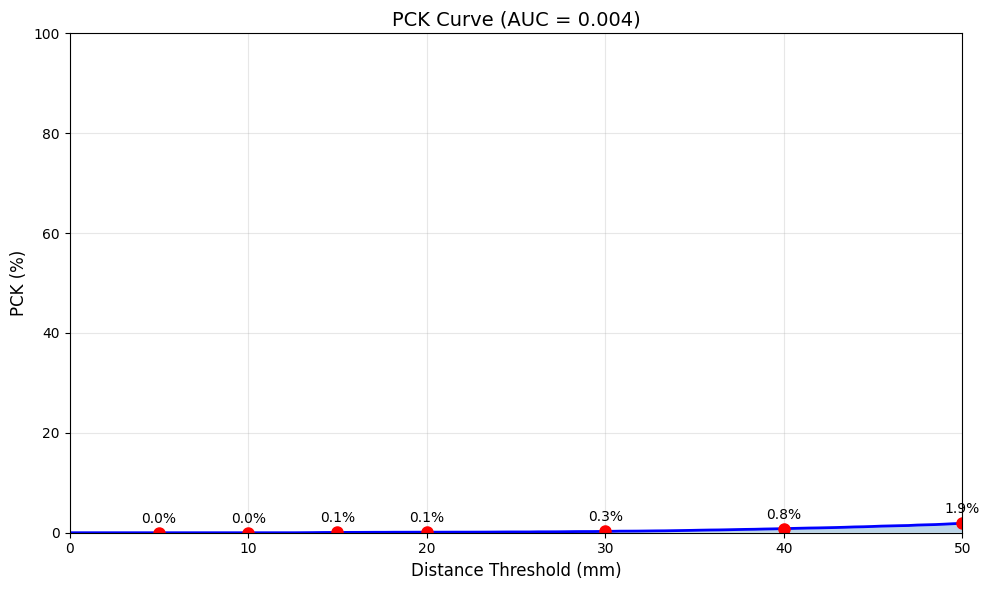

In [9]:
# Visualization 1: PCK Curve
plt.figure(figsize=(10, 6))
plt.plot(auc_thresholds, np.array(auc_pck_values) * 100, 'b-', linewidth=2)
plt.fill_between(auc_thresholds, 0, np.array(auc_pck_values) * 100, alpha=0.3)
plt.xlabel('Distance Threshold (mm)', fontsize=12)
plt.ylabel('PCK (%)', fontsize=12)
plt.title(f'PCK Curve (AUC = {auc:.3f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(config['auc_min'], config['auc_max'])
plt.ylim(0, 100)

# Add specific threshold markers
for threshold in config['pck_thresholds']:
    if threshold <= config['auc_max']:
        pck_val = pck_results[f'PCK@{threshold}mm']
        plt.plot(threshold, pck_val, 'ro', markersize=8)
        plt.text(threshold, pck_val + 2, f'{pck_val:.1f}%', 
                ha='center', fontsize=10)

plt.tight_layout()
if config['save_results']:
    plt.savefig(os.path.join(config['results_dir'], 'pck_curve.png'), dpi=150)
plt.show()

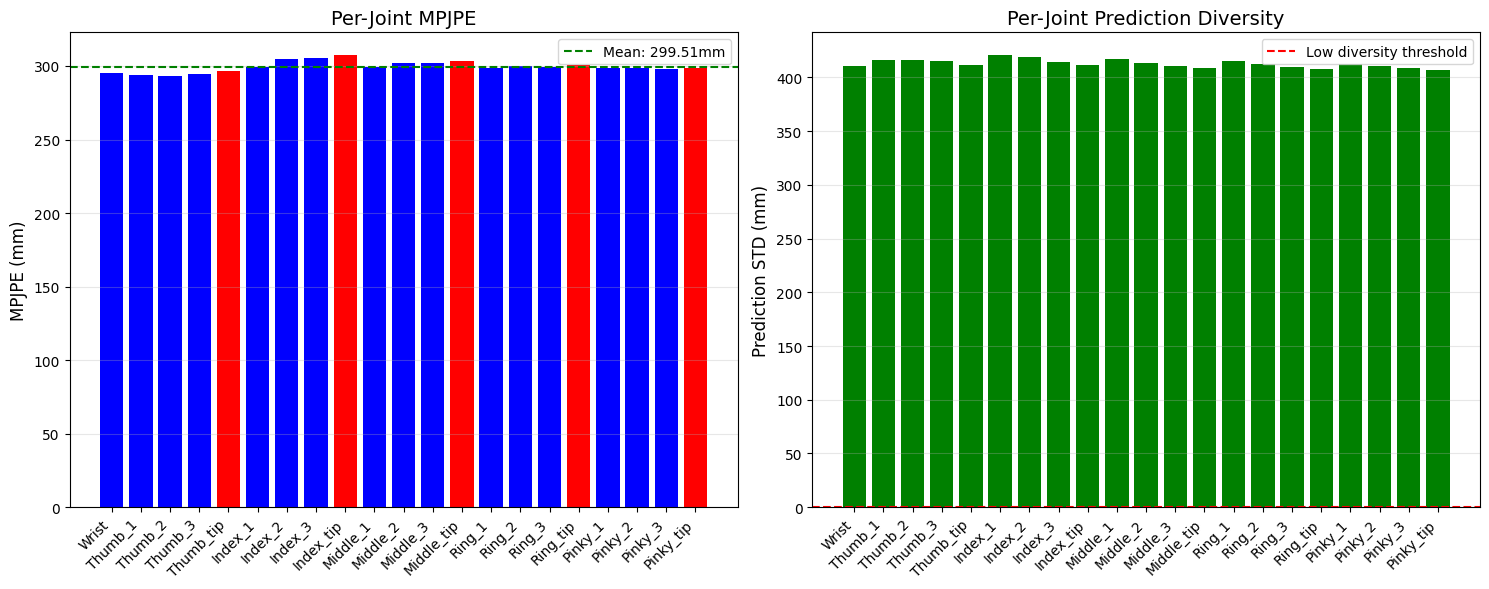

In [10]:
# Visualization 2: Per-Joint Error Heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of per-joint errors
joint_errors_list = [joint_mpjpe[i] for i in range(21)]
colors = ['red' if i in [4, 8, 12, 16, 20] else 'blue' for i in range(21)]  # Fingertips in red

bars = ax1.bar(range(21), joint_errors_list, color=colors)
ax1.set_xticks(range(21))
ax1.set_xticklabels(joint_names, rotation=45, ha='right')
ax1.set_ylabel('MPJPE (mm)', fontsize=12)
ax1.set_title('Per-Joint MPJPE', fontsize=14)
ax1.grid(True, axis='y', alpha=0.3)

# Add mean line
ax1.axhline(y=mpjpe_mean, color='green', linestyle='--', label=f'Mean: {mpjpe_mean:.2f}mm')
ax1.legend()

# Diversity visualization
std_per_joint = diversity_metrics['std_per_joint']
std_magnitude = np.linalg.norm(std_per_joint, axis=1)

bars2 = ax2.bar(range(21), std_magnitude, color='green')
ax2.set_xticks(range(21))
ax2.set_xticklabels(joint_names, rotation=45, ha='right')
ax2.set_ylabel('Prediction STD (mm)', fontsize=12)
ax2.set_title('Per-Joint Prediction Diversity', fontsize=14)
ax2.grid(True, axis='y', alpha=0.3)

# Add warning line for low diversity
ax2.axhline(y=0.5, color='red', linestyle='--', label='Low diversity threshold')
ax2.legend()

plt.tight_layout()
if config['save_results']:
    plt.savefig(os.path.join(config['results_dir'], 'per_joint_analysis.png'), dpi=150)
plt.show()

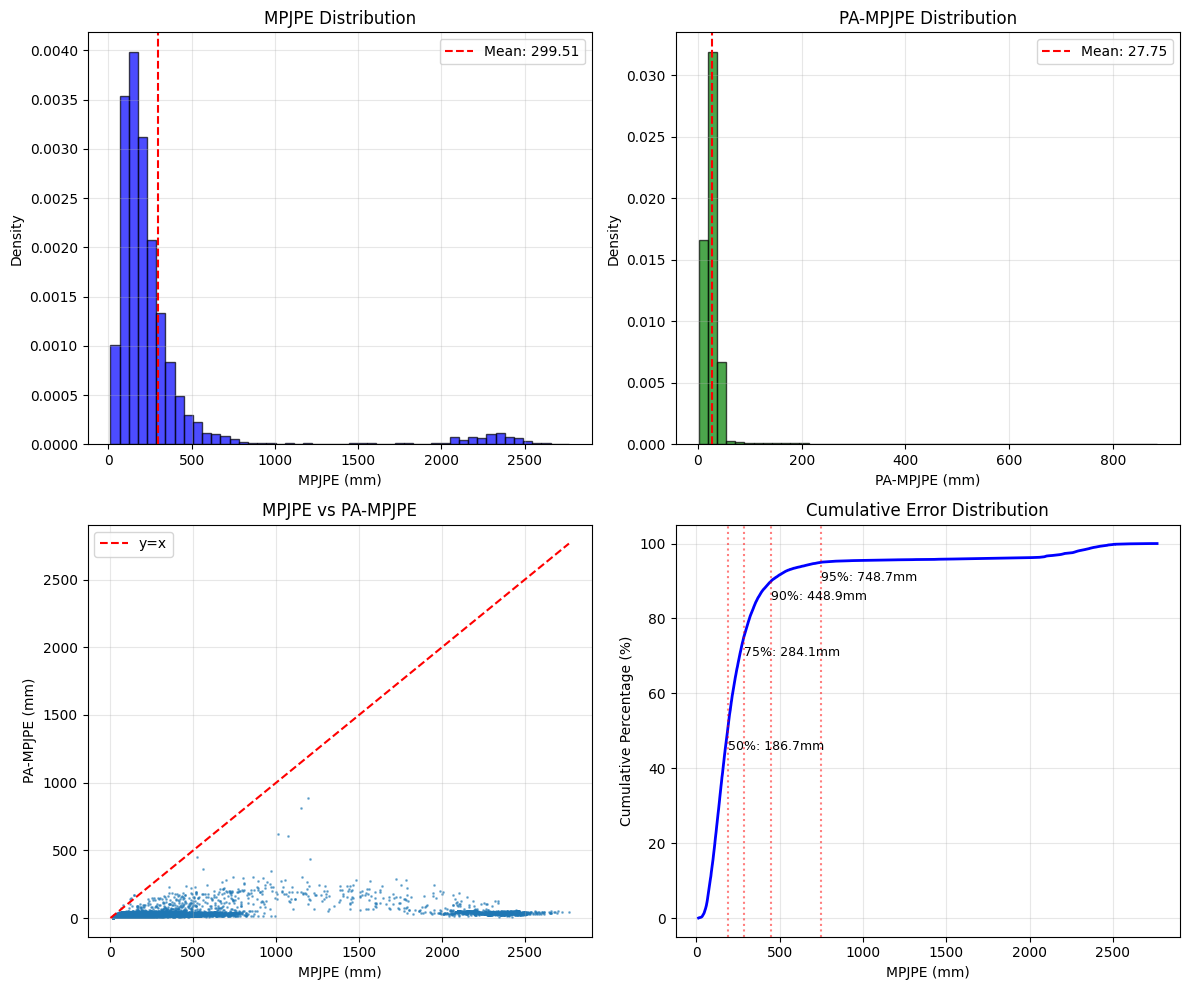

In [11]:
# Visualization 3: Error Distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MPJPE distribution
axes[0, 0].hist(all_mpjpe, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(mpjpe_mean, color='red', linestyle='--', label=f'Mean: {mpjpe_mean:.2f}')
axes[0, 0].set_xlabel('MPJPE (mm)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('MPJPE Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PA-MPJPE distribution
axes[0, 1].hist(all_pa_mpjpe, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(pa_mpjpe_mean, color='red', linestyle='--', label=f'Mean: {pa_mpjpe_mean:.2f}')
axes[0, 1].set_xlabel('PA-MPJPE (mm)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('PA-MPJPE Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MPJPE vs PA-MPJPE scatter
axes[1, 0].scatter(all_mpjpe, all_pa_mpjpe, alpha=0.5, s=1)
axes[1, 0].plot([0, max(all_mpjpe)], [0, max(all_mpjpe)], 'r--', label='y=x')
axes[1, 0].set_xlabel('MPJPE (mm)')
axes[1, 0].set_ylabel('PA-MPJPE (mm)')
axes[1, 0].set_title('MPJPE vs PA-MPJPE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative error distribution
sorted_mpjpe = np.sort(all_mpjpe)
cumulative = np.arange(1, len(sorted_mpjpe) + 1) / len(sorted_mpjpe) * 100

axes[1, 1].plot(sorted_mpjpe, cumulative, 'b-', linewidth=2)
axes[1, 1].set_xlabel('MPJPE (mm)')
axes[1, 1].set_ylabel('Cumulative Percentage (%)')
axes[1, 1].set_title('Cumulative Error Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add percentile markers
percentiles = [50, 75, 90, 95]
for p in percentiles:
    val = np.percentile(all_mpjpe, p)
    axes[1, 1].axvline(val, color='red', linestyle=':', alpha=0.5)
    axes[1, 1].text(val + 1, p - 5, f'{p}%: {val:.1f}mm', fontsize=9)

plt.tight_layout()
if config['save_results']:
    plt.savefig(os.path.join(config['results_dir'], 'error_distributions.png'), dpi=150)
plt.show()


Visualizing 10 sample predictions...


/home/n231/231nProjectV2/Advanced_Manipulation_Transformer/data/enhanced_dexycb.py:426: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_file)


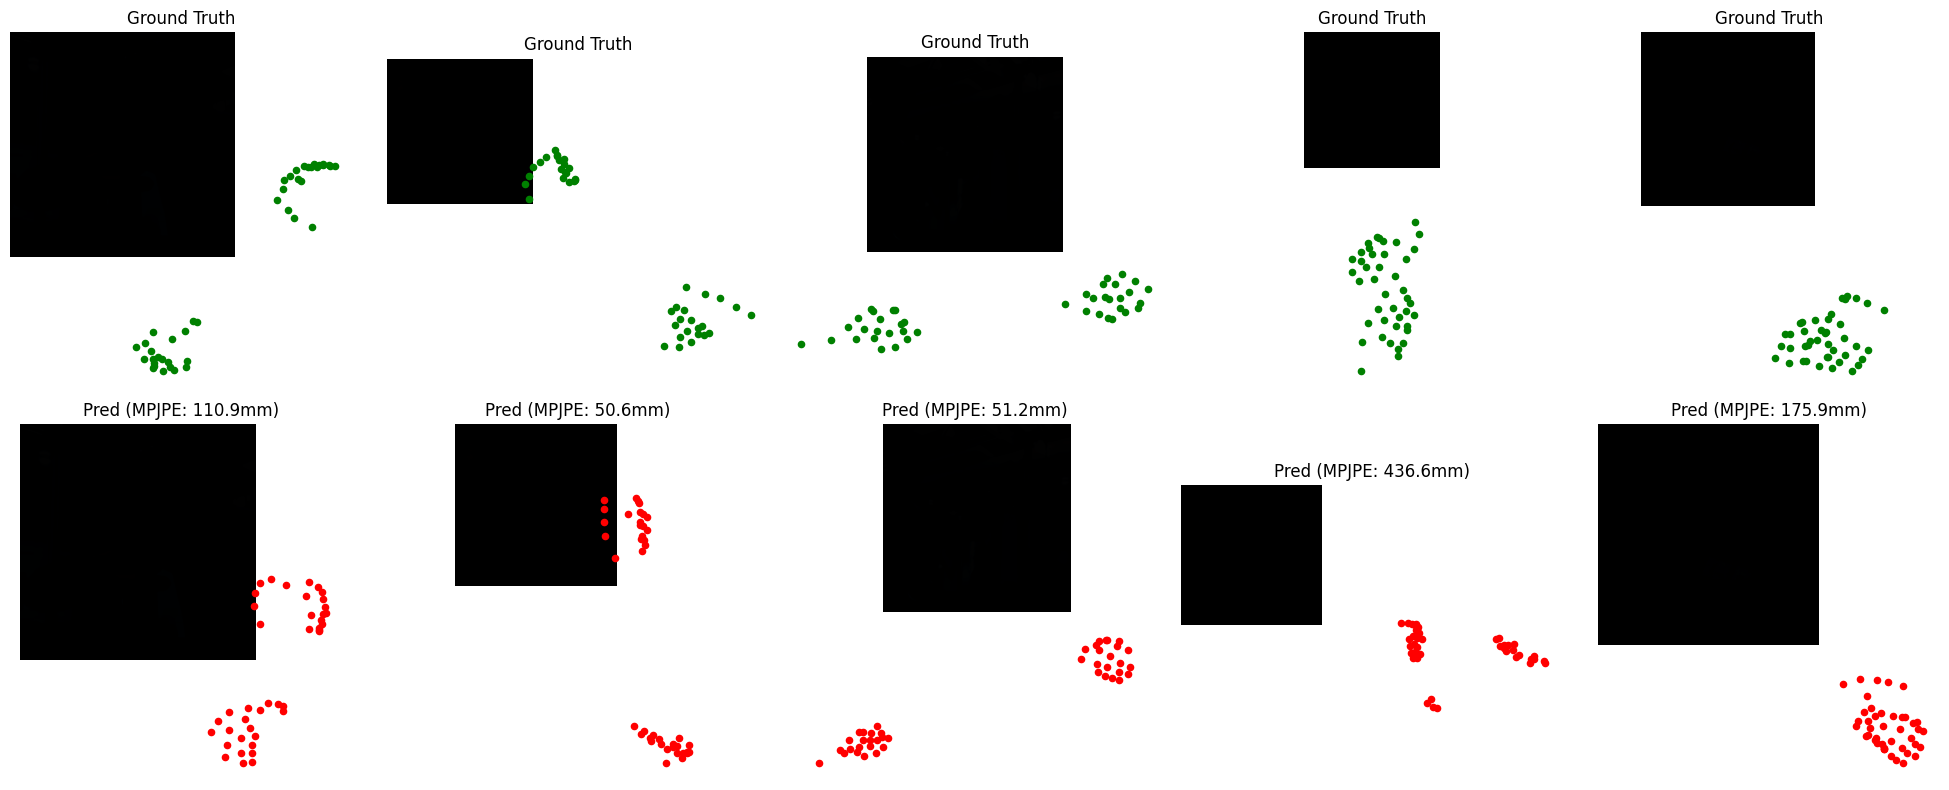

In [12]:
# Visualize sample predictions (optional)
if config['visualize_samples'] > 0:
    print(f"\nVisualizing {config['visualize_samples']} sample predictions...")
    
    # Get a few samples
    vis_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=True
    )
    
    fig, axes = plt.subplots(2, min(5, config['visualize_samples']), 
                            figsize=(4*min(5, config['visualize_samples']), 8))
    
    if config['visualize_samples'] == 1:
        axes = axes.reshape(2, 1)
    elif min(5, config['visualize_samples']) == 1:
        axes = axes.reshape(2, 1)
    
    with torch.no_grad():
        for idx, batch in enumerate(vis_loader):
            if idx >= config['visualize_samples']:
                break
            
            # Get predictions
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                    for k, v in batch.items()}
            
            # Fix batch for model (BFloat16 conversion and camera params)
            batch = fix_batch_for_model(batch, model)
            
            outputs = model(batch)
            
            # Extract data - use 'image' key
            if 'image' in batch:
                image = batch['image'][0].cpu()
            else:
                print(f"Warning: No image found in batch, skipping visualization {idx}")
                continue
            
            # Handle image format (could be CHW or HWC)
            if image.dim() == 3 and image.shape[0] in [3, 4]:  # CHW format
                image = image.permute(1, 2, 0).numpy()
            else:
                image = image.numpy()
                
            # Extract predictions
            if 'hand_joints' in outputs:
                pred_joints = outputs['hand_joints'][0].cpu().numpy()
            elif 'hand' in outputs and 'joints_3d_refined' in outputs['hand']:
                pred_joints = outputs['hand']['joints_3d_refined'][0].cpu().numpy()
            elif 'hand' in outputs and 'joints_3d' in outputs['hand']:
                pred_joints = outputs['hand']['joints_3d'][0].cpu().numpy()
            else:
                continue
            
            # Get ground truth 3D joints first
            if 'hand_joints_3d' in batch:
                gt_3d = batch['hand_joints_3d'][0].cpu().numpy()
            elif 'hand_joints' in batch:
                gt_3d = batch['hand_joints'][0].cpu().numpy()
            else:
                print(f"Warning: No ground truth joints found, skipping visualization {idx}")
                continue
                
            # Project to 2D for visualization
            if 'camera_intrinsics' in batch:
                K = batch['camera_intrinsics'][0].cpu().numpy()
                pred_2d = pred_joints @ K.T
                pred_2d = pred_2d[:, :2] / pred_2d[:, 2:3]
            else:
                pred_2d = pred_joints[:, :2] * 1000  # Just use x,y, scale to image space
                
            # Get ground truth 2D joints
            if 'hand_joints_2d' in batch:
                gt_2d = batch['hand_joints_2d'][0].cpu().numpy()
            else:
                # Project 3D to 2D
                if 'camera_intrinsics' in batch:
                    gt_2d = gt_3d @ K.T
                    gt_2d = gt_2d[:, :2] / gt_2d[:, 2:3]
                else:
                    gt_2d = gt_3d[:, :2] * 1000
            
            # Denormalize image if needed
            if image.max() <= 1.0:
                image = np.clip(image, 0, 1)
            else:
                image = np.clip(image / 255.0, 0, 1)
            
            # Plot
            col = idx % 5
            
            # Original image with GT
            axes[0, col].imshow(image)
            axes[0, col].scatter(gt_2d[:, 0], gt_2d[:, 1], c='green', s=20, label='GT')
            axes[0, col].set_title(f'Ground Truth')
            axes[0, col].axis('off')
            
            # Prediction
            axes[1, col].imshow(image)
            axes[1, col].scatter(pred_2d[:, 0], pred_2d[:, 1], c='red', s=20, label='Pred')
            
            # Compute error for this sample
            mpjpe_3d = np.mean(np.linalg.norm(pred_joints - gt_3d, axis=-1)) * 1000
            axes[1, col].set_title(f'Pred (MPJPE: {mpjpe_3d:.1f}mm)')
            axes[1, col].axis('off')
    
    plt.tight_layout()
    if config['save_results']:
        plt.savefig(os.path.join(config['results_dir'], 'sample_predictions.png'), dpi=150)
    plt.show()

In [13]:
# Summary Report
print("\n" + "="*60)
print("EVALUATION SUMMARY REPORT")
print("="*60)
print(f"Model: {config['checkpoint_path']}")
print(f"Test Set: {config['test_split']} ({len(test_dataset)} samples)")
print(f"\nKey Metrics:")
print(f"  - MPJPE: {mpjpe_mean:.2f} ± {mpjpe_std:.2f} mm")
print(f"  - PA-MPJPE: {pa_mpjpe_mean:.2f} ± {pa_mpjpe_std:.2f} mm")
print(f"  - PCK@20mm: {pck_results['PCK@20mm']:.2f}%")
print(f"  - AUC (0-50mm): {auc:.3f}")
print(f"  - Diversity: {diversity_metrics['mean_std_per_joint']:.4f} mm")

# Performance assessment
print("\nPerformance Assessment:")
if mpjpe_mean < 20:
    print("  ✅ Excellent performance (MPJPE < 20mm)")
elif mpjpe_mean < 50:
    print("  ✓ Good performance (MPJPE < 50mm)")
elif mpjpe_mean < 100:
    print("  ⚠️ Moderate performance (MPJPE < 100mm)")
else:
    print("  ❌ Poor performance (MPJPE > 100mm)")

if diversity_metrics['mean_std_per_joint'] < 0.5:
    print("  ❌ Mode collapse detected (low diversity)")
else:
    print("  ✅ Good prediction diversity")

print("="*60)


EVALUATION SUMMARY REPORT
Model: /home/n231/231nProjectV2/Advanced_Manipulation_Transformer/notebooks/outputs/full_featured/checkpoints/checkpoint_epoch_50.pth
Test Set: s0_val (23200 samples)

Key Metrics:
  - MPJPE: 299.51 ± 432.69 mm
  - PA-MPJPE: 27.75 ± 23.06 mm
  - PCK@20mm: 0.11%
  - AUC (0-50mm): 0.004
  - Diversity: 233.4111 mm

Performance Assessment:
  ❌ Poor performance (MPJPE > 100mm)
  ✅ Good prediction diversity
